In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import os
import torchvision.models as models

In [4]:
def generate_grating(size, orientation, spatial_frequency):

    x = np.linspace(0, size, size)
    y = np.linspace(0, size, size)
    X, Y = np.meshgrid(x, y)

    theta = np.deg2rad(orientation)
    freq = spatial_frequency * 2 * np.pi

    grating = np.sin(freq * (X * np.cos(theta) + Y * np.sin(theta))) * 255 # convert to grayscale 

    return grating

In [179]:
#### Simulate drifting gratings ####
# full-field drifting gratings consisted of a drifting sinusoidal grating
# at a single temporal frequency (1Hz) and contrast (80%). 
# presented at 12 different directions (separated by 30 degrees) and at 2
# different spatial frequencies (0.04 and 0.08 cycles per degree)

# for our purposes, we will simulate fixed drifting gratings 
# they will have 6 different orientations (0, 30, 60, 90, 120, 150 degrees)
# and 2 different spatial frequencies (0.04 and 0.08 cycles per degree)

orientations = [0, 30, 60, 90, 120, 150]
spatial_frequencies = [0.04, 0.08]
size = 224 # pixels
repeats = 40
gratings = np.zeros((repeats * len(orientations) * len(spatial_frequencies), size, size))
label_map = {
    0: [0, 1, 2, 3, 4, 5],
    1: [6, 7, 8, 9, 10, 11]
}
grating_labels = np.zeros((repeats * len(orientations) * len(spatial_frequencies)))

for i, orientation in enumerate(orientations):
    for j, spatial_frequency in enumerate(spatial_frequencies):
        for k in range(repeats):
            gratings[(k * len(orientations) * len(spatial_frequencies)) + (i * len(spatial_frequencies)) + j] = generate_grating(size, orientation, spatial_frequency)
            grating_labels[(k * len(orientations) * len(spatial_frequencies)) + (i * len(spatial_frequencies)) + j] = label_map[j][i]

# Shuffle the gratings
# np.random.shuffle(gratings)
print(f'shape of gratings array: {gratings.shape} (should be (N, 224, 224))')
print(f'shape of grating_labels array: {grating_labels.shape} (should be (N,))')

shape of gratings array: (480, 224, 224) (should be (N, 224, 224))
shape of grating_labels array: (480,) (should be (N,))


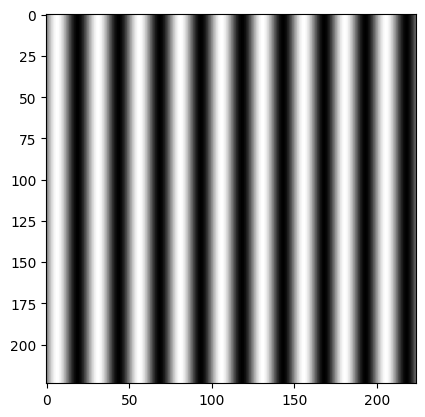

In [181]:
plt.imshow(gratings[0, :, :], cmap='gray')

In [182]:
## Load in the natural scenes images
# consisted of 118 natural images
# images 1-58 were from the Berkeley Segmentation Dataset (Martin et al., 2001)
# images 59-101 were from the van Hateren Natural Image Dataset (van Hateren and van der Schaaf, 1998)
# images 102-118 were from teh McGill Calibrated Colour Image Database (Olmos and Kingdom, 2004)

# images were presented in grayscale and were contrast normalized and resized to 1174 x 918 pixels
# images were luminance-matched (bug prevented proper matching; within 6%)

# presented for 0.25 seconds each, no inter-image gray period
# each presented ~50 times, in random order, and there were blank sweeps (i.e. mean luminence gray)
# roughly once every 100 images

from matplotlib.image import imread

repeats = 4
images = np.zeros((118 * repeats, 224, 224))
image_labels = np.zeros((118 * repeats,))
start_num = 12

# load in the images from the Berkeley Segmentation Dataset
file_list = os.listdir('/home/naomi/Downloads/BSDS300/images/train/')
for r in range(repeats):
    for i in range(118):
        image = imread(f'/home/naomi/Downloads/BSDS300/images/train/{file_list[i]}')
        image = np.dot(image, [0.2989, 0.5870, 0.1140]) # convert to grayscale
        images[(r * 118) + i] = image[int(image.shape[0]/2)-112:int(image.shape[0]/2)+112, int(image.shape[1]/2)-112:int(image.shape[1]/2)+112]
        image_labels[(r * 118) + i] = (i+start_num)

images = images.astype(int)
images.shape

(472, 224, 224)

In [191]:
# all_inputs = np.concatenate((gratings, images), axis=0)
all_inputs = images
all_inputs = all_inputs.reshape((-1, 1, 224, 224))
all_inputs = np.repeat(all_inputs, 3, axis=1) # convert to 3 channels
all_inputs.shape # (N, 3, 224, 224)

(472, 3, 224, 224)

In [192]:
# grating_id = 0
# natural_scenes_id = 1

# grating_labels = np.zeros(np.shape(gratings)[0])
# natural_scenes_labels = np.ones(np.shape(images)[0])

# all_labels = np.concatenate((grating_labels, natural_scenes_labels), axis=0)
# all_labels.shape

# all_labels = np.concatenate((grating_labels, image_labels), axis=0)
all_labels = image_labels
all_labels.shape

(472,)

In [193]:
### shuffling!!
indices = len(all_labels)
shuffled_indices = np.random.permutation(indices)

all_inputs = all_inputs[shuffled_indices]
all_labels = all_labels[shuffled_indices]

In [194]:
## Loading in the model -- ResNet18
# accepts inputs of shape [batch, 3, 224, 224]
from torchvision.models.feature_extraction import create_feature_extractor

resnet18 = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
).eval()

return_nodes = {
    'relu': 'stem',         # after initial conv1/bn1/relu
    'layer1': 'layer1',     # after layer1
    'layer2': 'layer2',     # after layer2
}

feature_extractor = create_feature_extractor(resnet18, return_nodes)

In [195]:
batch_size = 64
input = all_inputs[:batch_size, :, :, :]
input = torch.from_numpy(input)
input = input.float()
input.shape, input.type(), input.dtype

(torch.Size([64, 3, 224, 224]), 'torch.FloatTensor', torch.float32)

In [231]:
for p in resnet18.parameters(): p.requires_grad = False
with torch.no_grad(): 
    features = resnet18(input)

# split into train / test set and fit a linear regression 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
clf = LogisticRegression(max_iter=10000)
x_train, x_test, y_train, y_test = train_test_split(features, all_labels[:batch_size], test_size=0.2)

clf.fit(x_train, y_train)
acc = clf.score(x_test, y_test)

print(acc)

KeyboardInterrupt: 

In [ ]:
del all_features
for num_batch in range(7):
    input = all_inputs[num_batch * batch_size:(num_batch * batch_size) + batch_size]
    input = torch.from_numpy(input)
    input = input.float()
    features = resnet18(input)
    all_features = np.concatenate((all_features, features), axis=0) if 'all_features' in locals() else features

all_features.shape

In [ ]:
# split into train / test set and fit a linear regression 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
clf = LogisticRegression(max_iter=1000)
x_train, x_test, y_train, y_test = train_test_split(features, all_labels[:batch_size], test_size=0.2)

clf.fit(x_train, y_train)
acc = clf.score(x_test, y_test)

print(acc)

In [208]:
# fit regression for each layer
for i in range(10):
    for k, v in features.items():
        clf = LogisticRegression(max_iter=10000)
        v_gap = v.mean(dim=(2, 3))
        x_train, x_test, y_train, y_test = train_test_split(v_gap, all_labels[:batch_size], test_size=0.2)
        clf.fit(x_train, y_train)
        acc = clf.score(x_test, y_test)
        print(f"Accuracy for {k}: {acc}")

Accuracy for stem: 0.3076923076923077
Accuracy for layer1: 0.38461538461538464
Accuracy for layer2: 0.38461538461538464
Accuracy for stem: 0.3076923076923077
Accuracy for layer1: 0.3076923076923077
Accuracy for layer2: 0.46153846153846156
Accuracy for stem: 0.38461538461538464
Accuracy for layer1: 0.23076923076923078
Accuracy for layer2: 0.15384615384615385
Accuracy for stem: 0.3076923076923077
Accuracy for layer1: 0.3076923076923077


KeyboardInterrupt: 

#### Model v2 -- to run code below I had to switch into a different virtual environment and install just these packages

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
from skimage.filters import gabor_kernel
import copy
from PIL import Image
import matplotlib.pyplot as plt

In [22]:
class ConvNet(nn.Module):
    def __init__(self, in_channels=3, height=16, width=16):
        super(ConvNet, self).__init__()

        # Shared layers
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1) # takes input of size (batch, in_channels, height, width) and ouputs (batch, 16, height, width)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # outputs (batch, 32, height, width)
        self.skip = nn.Identity()  # Placeholder for skip connection
        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1) # expects concatenation of conv1 and conv2 outputs
        self.pool = nn.MaxPool2d(2, 2)

        # Task-specific heads
        self.input_size = int(64 * height/2 * width/2)  # Assuming input image size is 64x64

        self.grating_head = nn.Linear(self.input_size, 10)  # 10 classes for gratings
        self.natural_scene_head = nn.Linear(self.input_size, 10)  # 10 classes for natural scenes

    def forward(self, x):

        out_conv1 = self.relu(self.conv1(x))
        out_conv2 = self.relu(self.conv2(out_conv1))
        out_conv1_skip = self.skip(out_conv1)  # Skip connection
        
        out_concat = torch.cat((out_conv1_skip, out_conv2), dim=1)  # Concatenate along channel dimension
        out_conv3 = self.relu(self.conv3(out_concat))
        out_pool = self.pool(out_conv3)
        out_flat = out_pool.view(x.size(0), self.input_size)  # Flatten into shape (batch_size, input_size)

        # Task-specific outputs
        out_grating = self.grating_head(out_flat)
        out_natural_scene = self.natural_scene_head(out_flat)

        return out_grating, out_natural_scene

In [23]:
class GaborDataset(Dataset):
    def __init__(self, num_images=10000, img_size=32, orientations=10, frequencies=(0.08)):
        self.num_images = num_images
        self.img_size = img_size
        self.orientations = np.linspace(0, np.pi * 2, orientations, endpoint=False) # generate orientations evenly spaced between 0 and 2pi
        self.frequencies = frequencies

        # Pre-generate all images and labels
        self.images = []
        self.labels = []
        for _ in range(num_images):
            orientation_idx = np.random.randint(0, len(self.orientations))
            orientation = self.orientations[orientation_idx]
            frequency = self.frequencies[0] if len(self.frequencies) == 1 else np.random.choice(self.frequencies)
            kernel = gabor_kernel(frequency, theta=orientation, sigma_x=15, sigma_y=15)
            gabor_img = np.real(kernel)
            gabor_img = (gabor_img - gabor_img.min()) / (gabor_img.max() - gabor_img.min()) * 255
            gabor_img = gabor_img.astype(np.uint8)
            transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            gabor_img_transformed = transform(Image.fromarray(gabor_img))
            self.images.append(gabor_img_transformed)
            self.labels.append(orientation_idx)
        self.images = torch.stack(self.images)
        self.labels = np.array(self.labels) + 10 # shift labels to avoid overlap with natural scenes labels

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [24]:
transform_cifar = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar_test_loader = DataLoader(cifar_testset, batch_size=32, shuffle=False)

gabor_trainset = GaborDataset(num_images=5000, img_size=32, orientations=10, frequencies=(0.08,))
gabor_testset = GaborDataset(num_images=1000, img_size=32, orientations=10, frequencies=(0.08,))
gabor_test_loader = DataLoader(gabor_testset, batch_size=32, shuffle=False)

combined_trainset = ConcatDataset([cifar_trainset, gabor_trainset])
combined_loader = DataLoader(combined_trainset, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet(in_channels=1, height=32, width=32).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(combined_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        out_grating, out_natural_scene = model(inputs)

        is_cifar = labels < 10
        is_gabor = labels >= 10

        loss = 0
        if is_cifar.any():
            loss += criterion(out_natural_scene[is_cifar], labels[is_cifar])
        if is_gabor.any():
            loss += criterion(out_grating[is_gabor], labels[is_gabor] - 10)  # adjust labels for gabor
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item() if isinstance(loss, torch.Tensor) else 0

        if i % 100 == 99:    # print every 10 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0
    losses.append(running_loss / len(combined_loader))

[Epoch 1, Batch 100] loss: 32.548
[Epoch 1, Batch 200] loss: 26.323
[Epoch 1, Batch 300] loss: 24.832
[Epoch 1, Batch 400] loss: 23.467
[Epoch 1, Batch 500] loss: 22.990
[Epoch 1, Batch 600] loss: 22.917
[Epoch 1, Batch 700] loss: 22.078
[Epoch 1, Batch 800] loss: 21.243
[Epoch 1, Batch 900] loss: 21.085
[Epoch 1, Batch 1000] loss: 20.577
[Epoch 1, Batch 1100] loss: 19.550
[Epoch 1, Batch 1200] loss: 19.957
[Epoch 1, Batch 1300] loss: 19.977
[Epoch 1, Batch 1400] loss: 19.274
[Epoch 1, Batch 1500] loss: 18.878
[Epoch 1, Batch 1600] loss: 19.239
[Epoch 1, Batch 1700] loss: 19.004
[Epoch 2, Batch 100] loss: 17.354
[Epoch 2, Batch 200] loss: 18.097
[Epoch 2, Batch 300] loss: 17.767
[Epoch 2, Batch 400] loss: 17.686
[Epoch 2, Batch 500] loss: 17.506
[Epoch 2, Batch 600] loss: 17.863
[Epoch 2, Batch 700] loss: 17.124
[Epoch 2, Batch 800] loss: 17.964
[Epoch 2, Batch 900] loss: 16.812
[Epoch 2, Batch 1000] loss: 17.450
[Epoch 2, Batch 1100] loss: 17.166
[Epoch 2, Batch 1200] loss: 17.080
[Ep

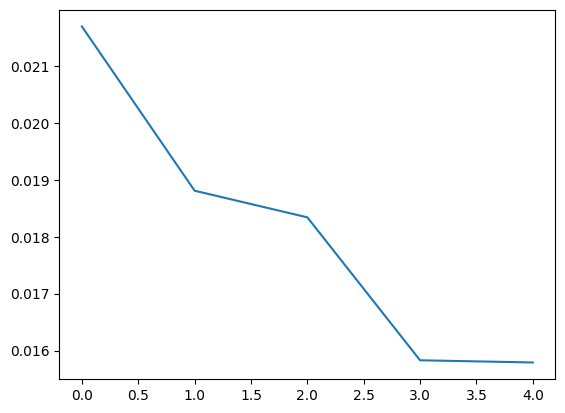

In [28]:
plt.plot(losses)